# Generic Nearest Neighborhood Analysis

In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
import math
import os

from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import scanpy as sc

def get_windows(job,n_neighbors):
    start_time,idx,tissue_name,indices = job
    job_start = time.time()
    
    print ("Starting:", str(idx+1)+'/'+str(len(exps)),': ' + exps[idx])

    tissue = tissue_group.get_group(tissue_name)
    to_fit = tissue.loc[indices][[X,Y]].values

    fit = NearestNeighbors(n_neighbors=n_neighbors).fit(tissue[[X,Y]].values)
    m = fit.kneighbors(to_fit)

    #sort_neighbors
    args = m[0].argsort(axis = 1)
    add = np.arange(m[1].shape[0])*m[1].shape[1]
    sorted_indices = m[1].flatten()[args+add[:,None]]

    neighbors = tissue.index.values[sorted_indices]
   
    end_time = time.time()
   
    print ("Finishing:", str(idx+1)+"/"+str(len(exps)),": "+ exps[idx],end_time-job_start,end_time-start_time)
    return neighbors.astype(np.int32)


In [3]:
#Choose this information and input based on above
ks = [5, 10, 20] # k=5 means it collects 5 nearest neighbors for each center cell
path_to_data = "/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/centroids.csv"

X = 'X'
Y = 'Y'
reg = 'region'
file_type = 'csv'

cluster_col = 'cell_type'
cellhier_path = '/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier'
keep_cols = [X,Y,reg,cluster_col]
save_path = '/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/predictions_skin'

# Data Preprocessing

##########################

In [4]:
#Import Data
n_neighbors = max(ks)
sys.path.append(cellhier_path)
from cellhier.general import *

cells = pd.read_csv(path_to_data)
cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],1)
sum_cols = cells[cluster_col].unique()
values = cells[sum_cols].values

/var/folders/5p/ztdw1y99307b6dsgd_7d24n40000gn/T/ipykernel_20470/1894502219.py:7: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  cells = pd.concat([cells,pd.get_dummies(cells[cluster_col])],1)


In [5]:
list(cells.columns)

['ID',
 'X',
 'Y',
 'Z',
 'cell_type',
 'CD31',
 'CD68',
 'DDB2',
 'KI67',
 'P53',
 'Skin',
 'T-Helper',
 'T-Killer',
 'T-Reg']

In [6]:
list(cells.columns)

['ID',
 'X',
 'Y',
 'Z',
 'cell_type',
 'CD31',
 'CD68',
 'DDB2',
 'KI67',
 'P53',
 'Skin',
 'T-Helper',
 'T-Killer',
 'T-Reg']

In [7]:
cells.head()

,ID,X,Y,Z,cell_type,CD31,CD68,DDB2,KI67,P53,Skin,T-Helper,T-Killer,T-Reg
0,1,188.500,342.500,10,T-Killer,0,0,0,0,0,0,0,1,0
1,1,136.600,161.400,20,T-Killer,0,0,0,0,0,0,0,1,0
2,2,437.500,363.500,20,T-Killer,0,0,0,0,0,0,0,1,0
3,3,203.500,512.000,20,T-Killer,0,0,0,0,0,0,0,1,0
4,1,155.579,204.895,0,T-Helper,0,0,0,0,0,0,1,0,0


In [8]:
cells.columns

Index(['ID', 'X', 'Y', 'Z', 'cell_type', 'CD31', 'CD68', 'DDB2', 'KI67', 'P53',
       'Skin', 'T-Helper', 'T-Killer', 'T-Reg'],
      dtype='object')

In [9]:
cells['region'] = 1

In [10]:
#Get each region
reg = 'region'
tissue_group = cells[[X,Y,reg]].groupby(reg)
exps = [str(i) for i in list(cells[reg].unique()) if str(i) != 'nan']
tissue_chunks = [(time.time(),exps.index(str(t)),t,a) for t,indices in tissue_group.groups.items() for a in np.array_split(indices,1)] 
tissues = [get_windows(job,n_neighbors) for job in tissue_chunks]

Starting: 1/1 : 1
Finishing: 1/1 : 1 16.255613088607788 16.255685091018677


In [11]:
#Loop over k to compute neighborhoods
out_dict = {}
for k in ks:
    for neighbors,job in zip(tissues,tissue_chunks):

        chunk = np.arange(len(neighbors))#indices
        tissue_name = job[2]
        indices = job[3]
        window = values[neighbors[chunk,:k].flatten()].reshape(len(chunk),k,len(sum_cols)).sum(axis = 1)
        out_dict[(str(tissue_name),k)] = (window.astype(np.float16),indices)
        
windows = {}
for k in ks:
   
    window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
    window = window.loc[cells.index.values]
    window = pd.concat([cells[keep_cols],window],1)
    windows[k] = window

/var/folders/5p/ztdw1y99307b6dsgd_7d24n40000gn/T/ipykernel_20470/1962601913.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
/var/folders/5p/ztdw1y99307b6dsgd_7d24n40000gn/T/ipykernel_20470/1962601913.py:17: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([cells[keep_cols],window],1)
/var/folders/5p/ztdw1y99307b6dsgd_7d24n40000gn/T/ipykernel_20470/1962601913.py:15: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  window = pd.concat([pd.DataFrame(out_dict[(exp,k)][0],index = out_dict[(exp,k)][1].astype(int),columns = sum_cols) for exp in exps],0)
/var/folders/5p/ztdw1y99307b6dsgd_7d24n40000gn/T/ipykernel_20

In [12]:
#Fill in based on above
k = 10
n_neighborhoods = 12
neighborhood_name = "neighborhood"+str(k)
k_centroids = {}

In [13]:
#producing what to plot
windows2 = windows[k]
windows2[cluster_col] = cells[cluster_col]

km = MiniBatchKMeans(n_clusters = n_neighborhoods,random_state=0)

labels = km.fit_predict(windows2[sum_cols].values)
k_centroids[k] = km.cluster_centers_
cells[neighborhood_name] = labels

1


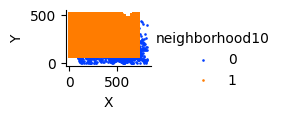

In [14]:
#modify figure size aesthetics for each neighborhood
# plt.rcParams["legend.markerscale"] = 0.1
figs = catplot(cells,X = 'X',Y='Y',exp = 'region',
               hue = 'neighborhood'+str(k),invert_y=True, size = 3, figsize=20)

In [13]:
exps = list(cells['Point'].unique()) 
[fig.savefig('neighborhoods_angelo/figs_12/'+f"{exp}.png", dpi=600) for exp, fig in zip(exps, figs)]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [19]:
neigh_list = [1, 10, 4, 6, 8]#[1,22,12,18,20]

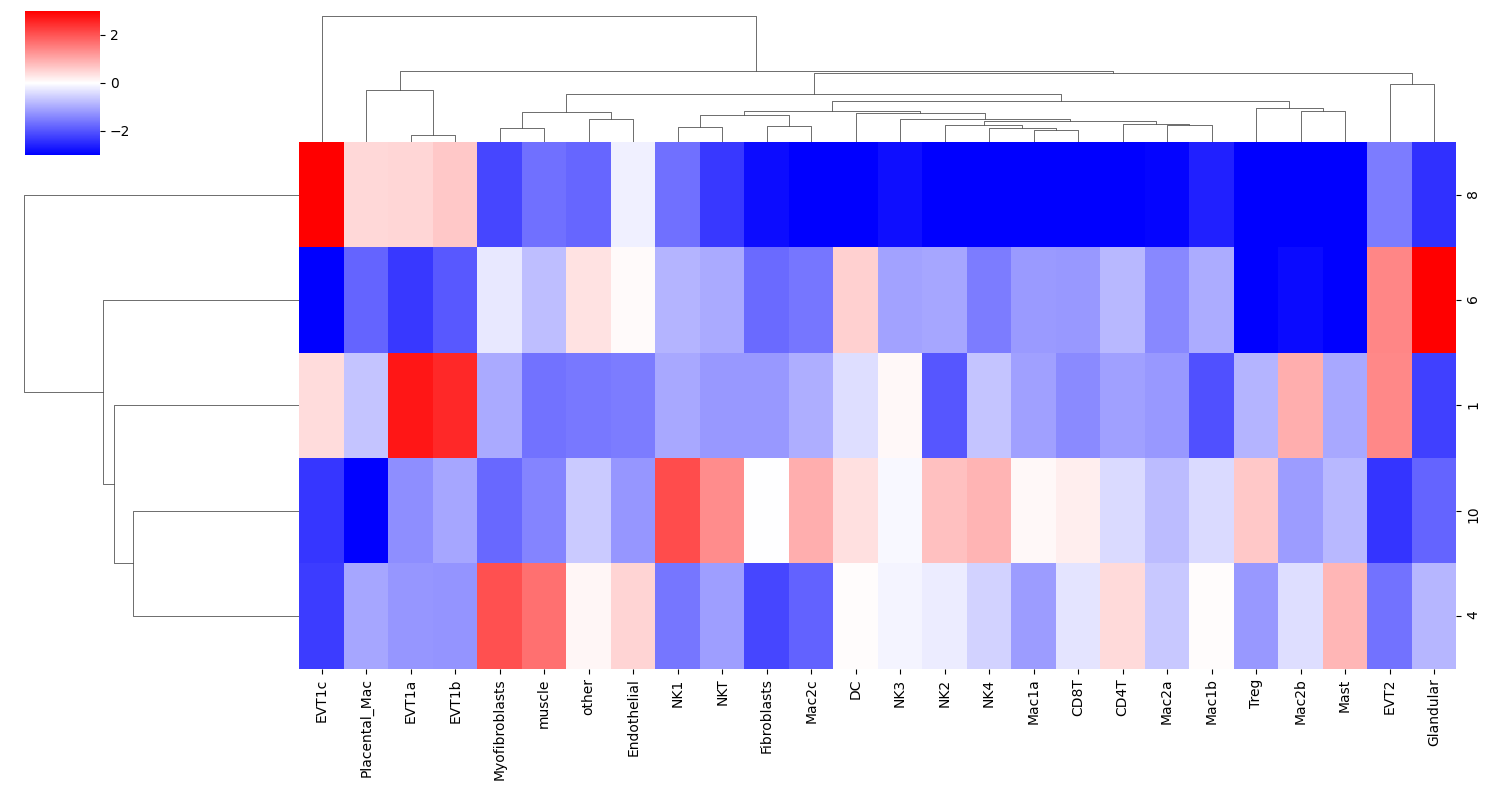

In [20]:
#this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc.iloc[neigh_list,:], vmin =-3,vmax = 3,cmap = 'bwr',figsize=(15,8))
#s.savefig(save_path+"celltypes_perniche_"+"_"+str(k)+".png", dpi=600)

10_31742_1_2


/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


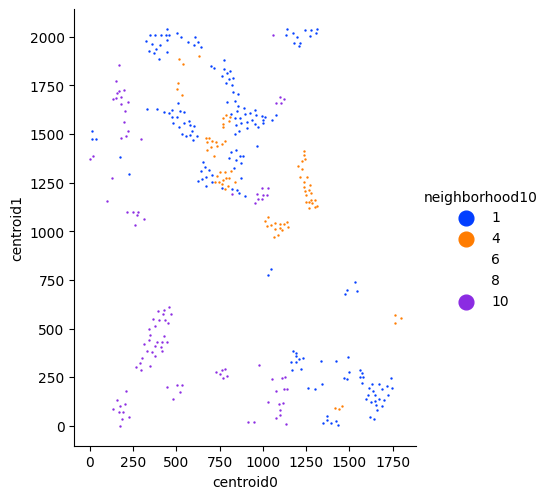

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


20_31789_14_2


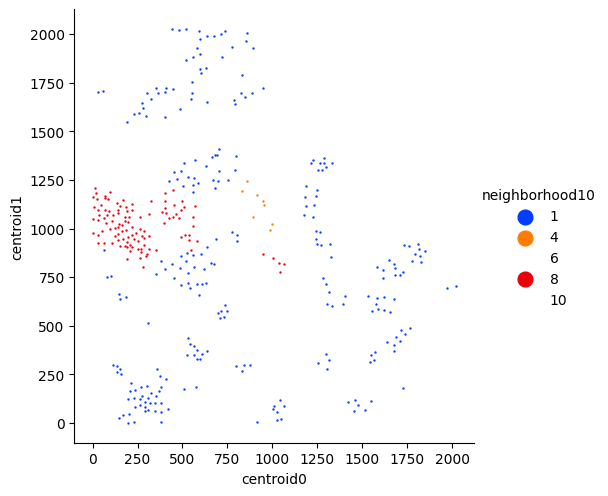

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


16_31772_4_5


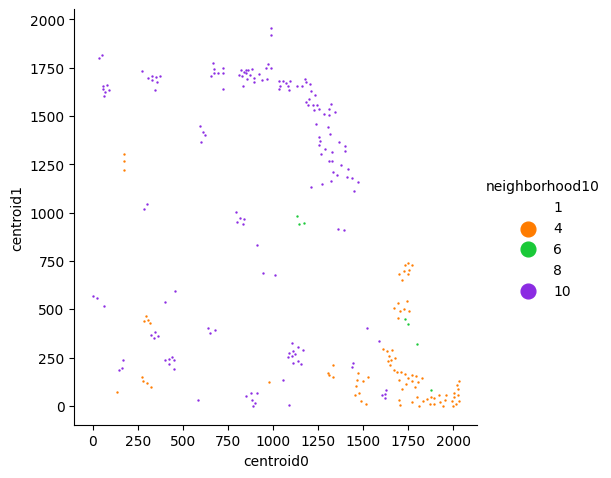

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


6_31730_10_11


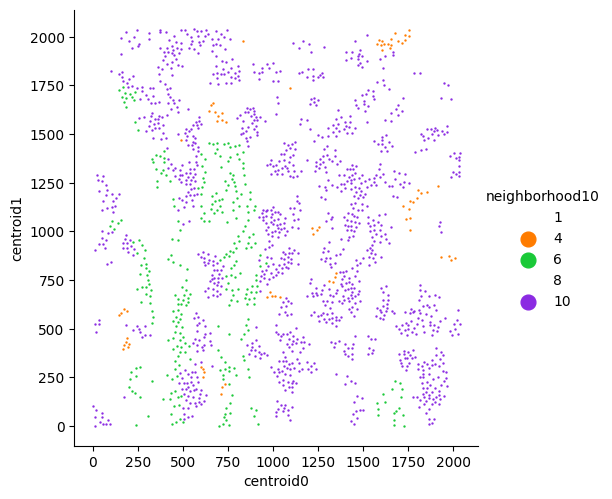

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


8_31736_12_17


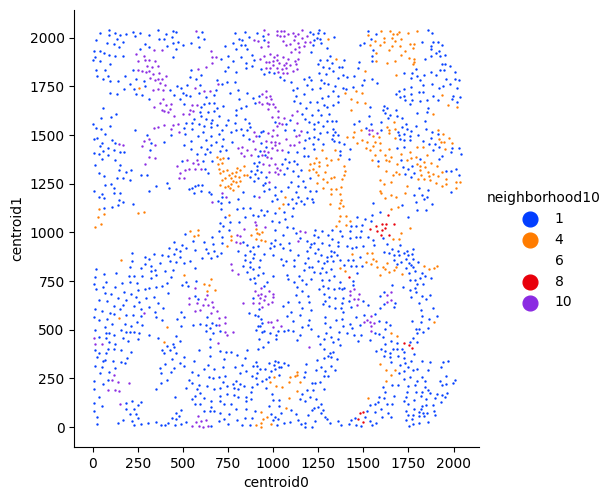

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


6_31731_15_8


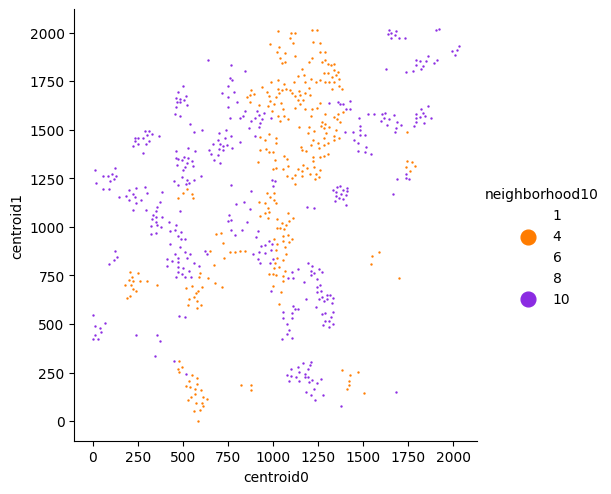

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


6_31727_8_9


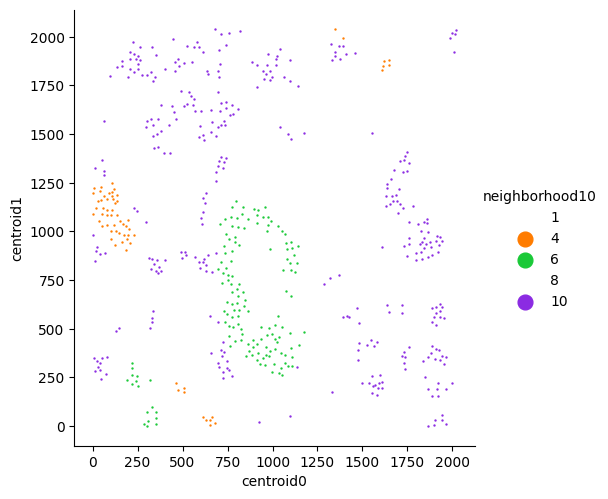

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


20_31791_18_13


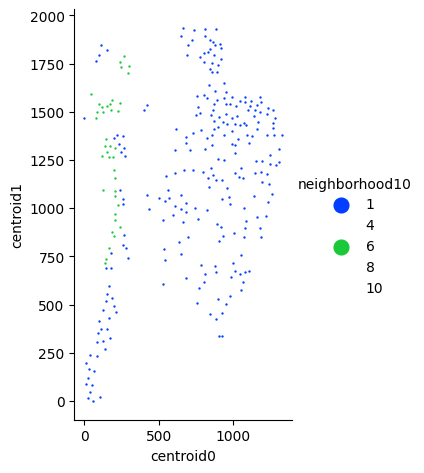

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


8_31736_12_19


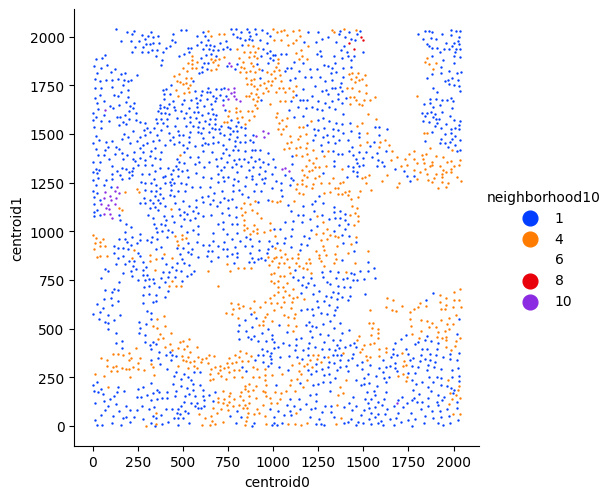

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()


8_31738_6_17


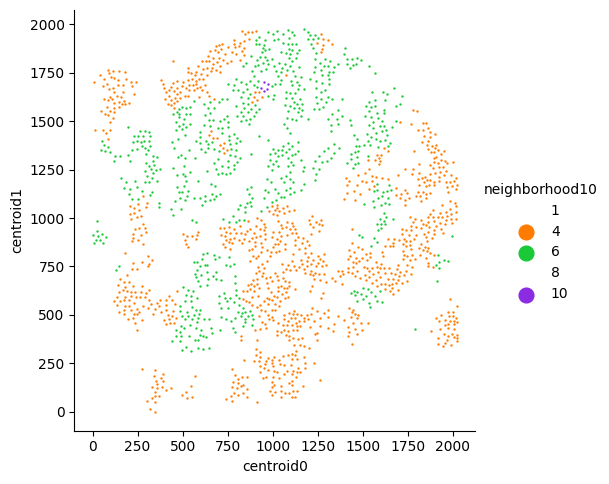

/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[X]=data[X]-data[X].min()
/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/cellhier/general.py:138: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[Y]=data[Y]-data[Y].min()
/Users/abhiroop/Developer/cns/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommo

18_31784_5_12


ValueError: left cannot be >= right

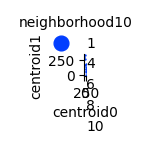

In [16]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 15
figs = catplot(cells.loc[cells.neighborhood10.isin(neigh_list)],X = 'centroid0',Y='centroid1',exp = 'Point',
               hue = 'neighborhood'+str(k),invert_y=True,size = 2,figsize=15)

In [23]:
save_path

'/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/predictions_angelo'

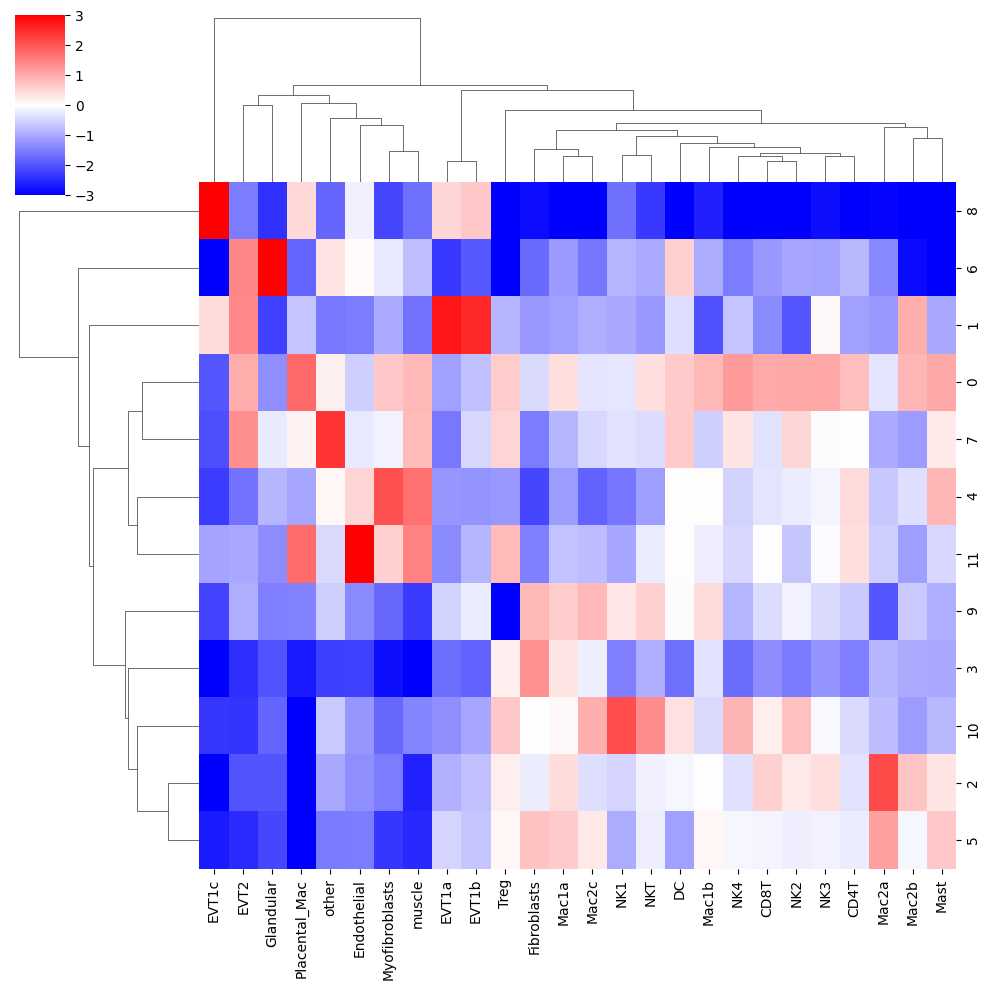

In [21]:
#this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
k_to_plot = k
niche_clusters = (k_centroids[k_to_plot])
tissue_avgs = values.mean(axis = 0)
fc = np.log2(((niche_clusters+tissue_avgs)/(niche_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc = pd.DataFrame(fc,columns = sum_cols)
s=sns.clustermap(fc, vmin =-3,vmax = 3,cmap = 'bwr', figsize=(10,10))
s.savefig(save_path+"/celltypes_perniche_"+"_"+str(k)+".png", dpi=600)

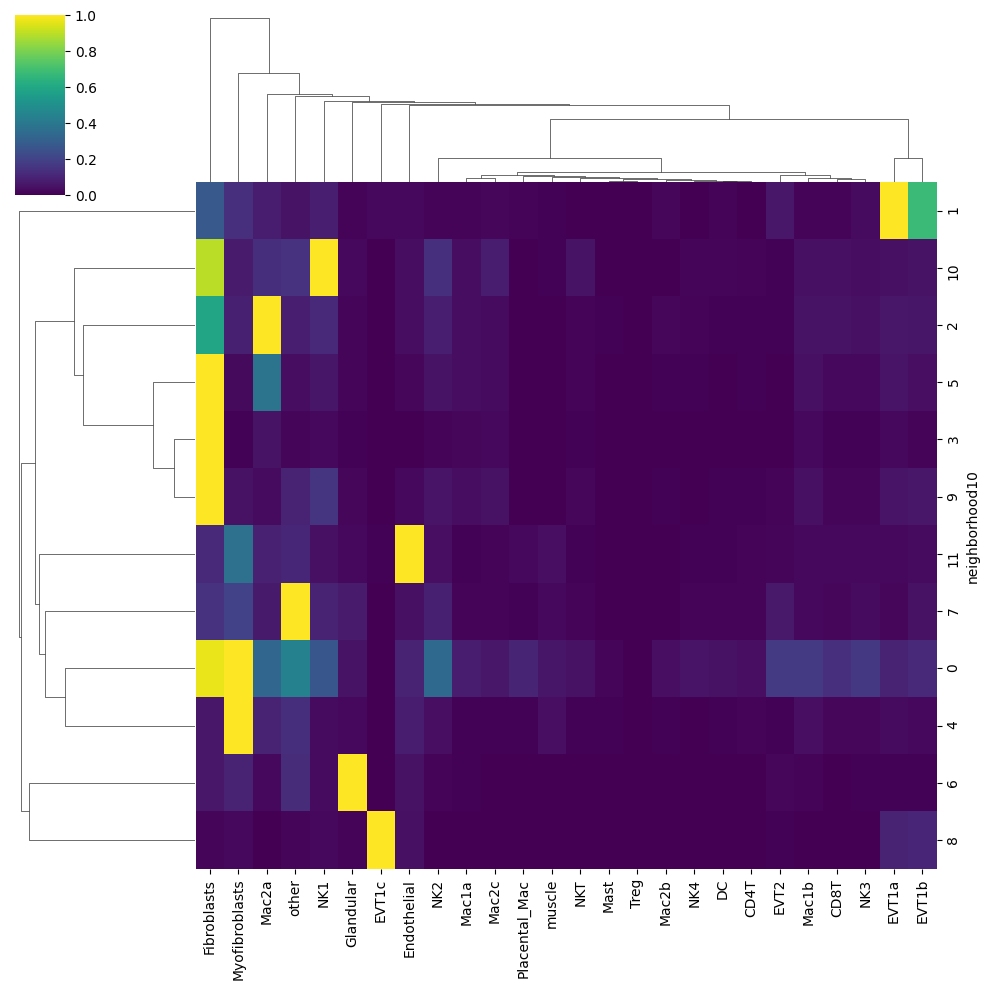

In [22]:
col_list = list(sum_cols)
hm = cells.groupby(['neighborhood10'])[col_list].mean()
sns.clustermap(hm, cmap='viridis', standard_scale=0)

In [ ]:
n_conversion_30 = {
    0: 'Secretory Epithelial',
    1: 'Mature Epithelial',
    2: 'Smooth Muscle',
    3: 'Plasma Cell Enriched',
    4: 'Adatpive Immune Enriched',
    5: 'Microvasculature',
    6: 'Stroma',
    7: 'Inner Follicle',
    8: 'Secretory Epithelial',
    9: 'Paneth Enriched',
   
    10: 'CD66+ Mature Epithelial',
    11: 'Innervated Smooth Muscle',
    12: 'Transit Amplifying Zone',
    13: 'Stroma & Innate Immune',
    14: 'CD8+ T Enriched IEL',
    15: 'CD66+ Mature Epithelial',
    16: 'Secretory Epithelial',
    17: 'Stroma',
    18: 'Transit Amplifying Zone',
    19: 'Plasma Cell Enriched',
    
    20: 'Transit Amplifying Zone',
    21: 'Innervated Stroma',
    22: 'Mature Epithelial',
    23: 'Smooth Muscle & Innate Immune',
    24: 'Plasma Cell Enriched',
    25: 'Innate Immune Enriched',
    26: 'Glandular Epithelial',
    27: 'CD8+ T Enriched IEL',
    28: 'Outer Follicle',
    29: 'Macrovasculature',

}
cells['Neighborhood']=cells['neighborhood10'].map(n_conversion_30)
cells['Neighborhood'].unique()

In [ ]:
pal_color = {
'CD44hi Tumor': 'tan',
 'Tumor': 'gray',
 'Ki67+ Tumor': 'beige',
 'Ki67+ TYRP1hi Tumor': 'brown',
 'Ki67+ CD71hi Tumor': 'orange',
 'APC Enriched Tumor': 'green',
 'Inflamed Tumor': 'magenta',
 'Vascularized Immune Infiltrate': 'black',
 'Unproductive T cell Tumor Interface': 'red',
 'Immune Infiltrate': 'skyblue',
 'TYRP1hi Tumor': 'olive',
 'Productive T cell Tumor Interface': 'blue',
 'Neutrophil Enriched Immune Infiltrate': 'yellow',
 'Neutrophil Enriched': 'gold'
}

pal_color_cells = {
  'EGFR+ Epithelial cell':'blue',
 'Smooth muscle cell':'red',
 'Epithelial cell':'yellow',
  'Nerve cell':'magenta',
  'Macrophage':'orange',  
    'CD4+ Treg':'green',
    'Endothelial cell':'brown', 
     'CD8+ T cell':'black',
 'Intestinal Epithelial cell':'gray',
  'Neutrophil':'skyblue',
 'Parietal cell':'fuchsia',
   'Plasma cell':'gold',  
     'NK cell':'plum',
   'CD4+ T cell':'yellowgreen',
   'CK7+ Epithelial cell':'tan',
   'Neck cell':'navy',
  'Neuroendocrine cell':'bisque',   
 'Chief cell':'goldenrod',
  'Goblet cell':'blueviolet',
  'Foveolar cell':'darkorange',   
 'Stromal cell':'teal',
 'PDPN+ Stromal cell':'olive',
 'p63+ EGFR+ Epithelial cell':'dimgray',
 'Gastric mucouse secreting cell':'indigo',
 'Biglycan+ Stromal cell':'lightcoral',
 'Dendritic cell':'cyan',
 'Paneth cell':'ivory',
 'B cell':'beige',
 'Squamous Epithelial cell':'darkblue',
 'Immune unknown cell':'lightcyan',
 'p63+ Epithelial cell':'royalblue',
}

In [ ]:
cell_list = list(cells['lineage'].unique())
neigh_list = list(cells.Neighborhood.unique())
color_list=list(pal_color_cells.values())
dict_cell = dict(zip(cell_list, color_list))
dict_neigh = dict(zip(neigh_list, color_list))
dict_neigh

In [ ]:
dict_neigh2 = {
 'Transit Amplifying Zone': 'darkblue',
 'Microvasculature': 'black',
 'Adatpive Immune Enriched': 'orange',
 'Glandular Epithelial': 'darkorange',
 'CD66+ Mature Epithelial': 'firebrick',
 'Stroma & Innate Immune': 'brown',
 'CD8+ T Enriched IEL': 'green',
 'Mature Epithelial': 'magenta',
 'Innate Immune Enriched': 'skyblue',
 'Outer Follicle': 'navy',
 'Plasma Cell Enriched': 'yellow',
 'Innervated Stroma': 'blueviolet',
 'Stroma': 'gray',
 'Macrovasculature': 'gold',
 'Secretory Epithelial': 'yellowgreen',
 'Smooth Muscle': 'red',
 'Innervated Smooth Muscle': 'lightgreen',
 'Inner Follicle': 'blue',
 'Smooth Muscle & Innate Immune': 'tan',
 'Paneth Enriched': 'lightblue'}

In [ ]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 8
figs_n = catplot(cells,X = 'centroid0',Y='centroid1',exp = 'Point',
               hue = 'Neighborhood',invert_y=True,size = 1,figsize=8, palette=dict_neigh2)

In [ ]:
neigh_data = pd.DataFrame({
    'Neighborhood':list(dict_neigh2.keys()),
    'color':list(dict_neigh2.values())
})
neigh_data.set_index(keys='Neighborhood',inplace=True)
neigh_data

In [ ]:
#this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
#font size of graph
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

#Settings for graph
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [ ]:
save_path = '/Users/abhiroop/Developer/cns/neighborhood_scripts_sharing/neighborhoods_angelo/'

In [ ]:
#this plot shows the types of cells (ClusterIDs) in the different niches (0-9)
values = cells[sum_cols].values
sum_cols = cells['lineage'].unique()
#cells.rename(columns=n_conversion_cell, inplace=True)
cells[sum_cols]

#Find cell frequency within the neighborhoods
cell_list = list(sum_cols)
cell_list.append('Neighborhood')
subset = cells[cell_list]
niche_sub = subset.groupby('Neighborhood').sum()
niche_df = niche_sub.apply(lambda x: x/x.sum() * 10, axis=1)
neigh_clusters = niche_df.to_numpy()

tissue_avgs = values.mean(axis = 0)
fc_2 = np.log2(((neigh_clusters+tissue_avgs)/(neigh_clusters+tissue_avgs).sum(axis = 1, keepdims = True))/tissue_avgs)
fc_2 = pd.DataFrame(fc_2,columns = sum_cols)
fc_2.set_index(niche_df.index, inplace=True)
s=sns.clustermap(fc_2, vmin =-3,vmax = 3,cmap = 'bwr', figsize=(12,8), row_colors=[neigh_data.reindex(fc_2.index)['color']],\
                cbar_pos=(0.01,0.07,0.03,0.1))

s.ax_row_dendrogram.set_visible(False)
s.ax_col_dendrogram.set_visible(False)
s.ax_heatmap.set_ylabel("", labelpad=25)
s.ax_heatmap.tick_params(axis='y', pad=15)
s.ax_heatmap.yaxis.set_ticks_position("left")

s.savefig(save_path+"neighborhood_heatmap_30_10nn.png", dpi=600)
print(save_path)

In [ ]:
dict_cell

In [ ]:
dict_cell2 = {
    'NK': 'blue',
 'Enterocyte': 'magenta',
 'MUC1+ Enterocyte': 'yellow',
 'TA': 'skyblue',
 'CD66+ Enterocyte': 'darkorange',
 'Paneth': 'green',
 'Smooth muscle': 'red',
 'Cycling TA': 'tan',
 'M1 Macrophage': 'gray',
 'Goblet': 'indigo',
 'Neuroendocrine': 'yellowgreen',
 'CD57+ Enterocyte': 'fuchsia',
 'Lymphatic': 'plum',
 'CD8+ T': 'gold',
 'DC': 'blueviolet',
 'M2 Macrophage': 'bisque',
 'B': 'navy',
 'Neutrophil': 'goldenrod',
 'Endothelial': 'black',
 'Plasma': 'yellow',
 'CD4+ T cell': 'brown',
 'Stroma': 'dimgray',
 'Nerve': 'olive',
 'ICC': 'teal',
 'CD7+ Immune': 'lightcoral'}


In [ ]:
cells.unique_region.unique()

In [ ]:
sample_list = ['B005_Proximal Jejunum','B006_Proximal Jejunum', 'B004_Duodenum', 'B006_Ascending', ]

In [ ]:
cells

In [ ]:
#modify figure size aesthetics for each neighborhood
cell_list = ['Paneth', 'Neuroendocrine']
plt.rcParams["legend.markerscale"] = 5
figs = catplot(cells.loc[cells['lineage'].isin(cell_list)],X = 'centroid0',Y='centroid1',exp = 'Point',
               hue = 'lineage',invert_y=True,size = 1,figsize=8)

In [ ]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 8
figs_c = catplot(cells,X = 'centroid0',Y='centroid1',exp = 'Point',
               hue = 'lineage',invert_y=True,size = 0.5,figsize=8,palette=dict_cell2)

In [ ]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 24
figs_cs = catplot(cells.loc[cells.unique_region.isin(sample_list)],X = 'x',Y='y',exp = 'unique_region',
               hue = 'Cell Type',invert_y=True,size = 1,figsize=8,palette=dict_cell2)

In [ ]:
#modify figure size aesthetics for each neighborhood
plt.rcParams["legend.markerscale"] = 24
figs_ns = catplot(cells.loc[cells.unique_region.isin(sample_list)],X = 'x',Y='y',exp = 'unique_region',
               hue = 'Neighborhood',invert_y=True,size = 1,figsize=8,palette=dict_neigh2)

In [ ]:
for n,f in enumerate(figs_cs):
    f.savefig(save_path+'HuBMAP_cellmap{}.png'.format(n), dpi=600)
for n,f in enumerate(figs_ns):
    f.savefig(save_path+'HuBMAP_neighmap{}.png'.format(n), dpi=600)

In [ ]:
cells_out = cells.drop(columns=sum_cols)
cells_out.columns

In [ ]:
drop_list = ['neighborhood10', 'Unnamed: 0']#, 'neighborhood20','Unnamed: 0',]
cells_out.drop(columns=drop_list, inplace=True)
cells_out.columns

In [ ]:
df_dict = {}
for tissue in list(cells_out.Tissue_location.unique()):
    df_dict[tissue] = cells_out.loc[cells_out.Tissue_location==tissue]
    df_dict[tissue].to_csv(save_path+tissue+'_'+'4_12_HuBMAP_Neighborhoods.csv')

In [ ]:
cells_out.to_csv(save_path+'4_12_HuBMAP_Neighborhoods.csv')

In [ ]:
def df_to_adata(df, list_keep):
    #Prepare for making into anndata format so that obs and data are separate
    dfsc = df.drop(columns = list_keep)
    #Convert to anndata format
    adata = sc.AnnData(dfsc)
    adata.obs = df[list_keep]
    #choose marker sets to analyze 
    m_list = dfsc.columns.to_list()
    return adata, m_list

In [ ]:
list_obs = [x for x in ['Unnamed: 0', 'MUC2', 'SOX9', 'MUC1', 'CD31', 'Synapto', 'CD49f',
       'CD15', 'CHGA', 'CDX2', 'ITLN1', 'CD4', 'CD127', 'Vimentin', 'HLADR',
       'CD8', 'CD11c', 'CD44', 'CD16', 'BCL2', 'CD3', 'CD123', 'CD38', 'CD90',
       'aSMA', 'CD21', 'NKG2D', 'CD66', 'CD57', 'CD206', 'CD68', 'CD34',
       'aDef5', 'CD7', 'CD36', 'CD138', 'CD45RO', 'Cytokeratin', 'CD117',
       'CD19', 'Podoplanin', 'CD45', 'CD56', 'CD69', 'Ki67', 'CD49a', 'CD163',
       'CD161', 'first_index', 'x', 'y', 'tissue', 'donor', 'region', 'OLFM4',
       'FAP', 'CD25', 'CollIV', 'CK7', 'Xcorr', 'Ycorr', 'unique_region',
       'neigh_name', 'neigh_sub1', 'Preservation_method', 'Tissue_location',
       'array', 'Cell Type', 'Cell Type em', 'Cell subtype', 'machine', 'MUC6',
       'neighborhood10', 'Neighborhood'] if x not in ['first_index', 'neigh_name', 'neigh_sub1', 'Preservation_method', 'machine']]
adata, mlist = df_to_adata(df=cells, list_keep=list_obs)
adata

In [ ]:
save_path

In [ ]:
sc.settings.figdir='neighborhood_scripts_sharing/neighborhoods'
sc.settings.set_figure_params(dpi=80, facecolor='white',dpi_save=300, transparent=True, frameon=False, fontsize=22)
plt.rcParams["legend.markerscale"] = 1

In [ ]:
adata_sub = sc.pp.subsample(adata, fraction=0.05, copy=True)
adata_sub

In [ ]:
adata_sub.X

In [ ]:
sc.pp.neighbors(adata_sub, n_neighbors=10)
sc.tl.umap(adata_sub)
sc.pl.umap(adata_sub, color ='Neighborhood')

In [ ]:
neigh_list = list(adata.obs.Neighborhood.unique())
neigh_list

In [ ]:
pal_list = []
for neigh in neigh_list:
    col = dict_neigh2[neigh]
    pal_list.append(col)
pal_list

In [ ]:
sc.pl.umap(adata, color ='Neighborhood', palette=pal_list)

In [ ]:
dict_neigh2 = {
 'Transit Amplifying Zone': 'darkblue',
 'Microvasculature': 'black',
 'Adatpive Immune Enriched': 'orange',
 'Glandular Epithelial': 'darkorange',
 'CD66+ Mature Epithelial': 'firebrick',
 'Stroma & Innate Immune': 'brown',
 'CD8+ T Enriched IEL': 'green',
 'Mature Epithelial': 'magenta',
 'Innate Immune Enriched': 'skyblue',
 'Outer Follicle': 'navy',
 'Plasma Cell Enriched': 'yellow',
 'Innervated Stroma': 'blueviolet',
 'Stroma': 'gray',
 'Macrovasculature': 'gold',
 'Secretory Epithelial': 'yellowgreen',
 'Smooth Muscle': 'red',
 'Innervated Smooth Muscle': 'lightgreen',
 'Inner Follicle': 'blue',
 'Smooth Muscle & Innate Immune': 'tan',
 'Paneth Enriched': 'lightblue'}

In [ ]:
palette= ['red','mediumpurple', 'orange','lightskyblue', 'dodgerblue',  'thistle']